In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

In [3]:
# running experiments
from experiments.run_experiment import (
    TrainingConfig,
    EvaluateConfig,
)
from experiments.run_sweep import run_sweep, plot_sweep_training, plot_sweep_evaluation
from experiments.sweep_utils import asymmetric_alphas

# environments
from environments.fronzenlake import FrozenLakeConfig, get_frozenlake_env

# SARSA Variant agent
from agents.sarsa_td0_confirmation_bias import SarsaTD0ConfirmationBiasConfig, SarsaTD0ConfirmationBiasAgent

# metrics for training
from metrics.learning_mertrics import total_reward_per_episode, episode_won_frozenlake
from metrics.frustration_metrics import (
    total_td_error_per_episode,
    frustration_rate_per_episode,
    tail_frustration_per_episode,
    cvar_tail_frustration_per_episode,
)

# external libraries
import numpy as np

## Environments

In [4]:
# env_config = FrozenLakeConfig(map_name="4x4", is_slippery=False)
env_config = FrozenLakeConfig(
    map_name="4x4",
    is_slippery=False,
    reward_schedule=(1.0, -1.0, -0.0),
    
)

## Agents

In [5]:
## Agents
# sarsa_td0 agent
agent_factory = SarsaTD0ConfirmationBiasAgent

sarsa_td0_config = SarsaTD0ConfirmationBiasConfig(
    alpha_conf=0.2,
    alpha_disconf=0.2,
    gamma=0.99,
    epsilon=0.3,
    reward_metrics={
        "total_reward_per_episode": total_reward_per_episode,
        "episode_won": episode_won_frozenlake,
    },
    td_error_metrics={
        "total_td_error_per_episode": total_td_error_per_episode,
        "frustration_rate_per_episode": frustration_rate_per_episode,
        "tail_frustration_per_episode": lambda td: tail_frustration_per_episode(
            td, percentile=0.90
        ),
        "cvar_tail_frustration_per_episode": lambda td: cvar_tail_frustration_per_episode(
            td, percentile=0.90
        ),
    },
)

## Sweep configuration

In [17]:
base_train = TrainingConfig(
    name="sarsa_frozenlake",
    num_train_episodes=4000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="sarsa_frozenlake",
    num_eval_episodes=2000,
    seed=1,
    env_kwargs={"config": env_config},
)

In [18]:
# different q_tables
env = get_frozenlake_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q_0 = np.zeros((num_states, num_actions), dtype=np.float64)
q_1 = np.ones((num_states, num_actions), dtype=np.float64)
q_neg_1 = -np.ones((num_states, num_actions), dtype=np.float64)

In [19]:
# confirmation-bias sweep
ratios = [0.5, 1.0, 1.5]  # alpha_conf / alpha_disconf
base_alphas = [0.2]  # overall learning-scale options
seeds = list(range(10))  # 20 different seeds

reward_schedules = [
    (1.0, -1.0, 0.0),  # standard reward schedule
]

sweep = {
    "agent_kwargs": [
        {
   #         "alpha_conf": base_alpha,
  #          "alpha_disconf": base_alpha / ratio,
            "seed": seed,
        }
   #     for base_alpha in base_alphas
   #     for ratio in ratios
        for seed in seeds
    ],
    "env_kwargs": [
        {"reward_schedule": reward_schedule} for reward_schedule in reward_schedules
    ],
}

## Results

In [20]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_frozenlake_env,
    agent_factory=agent_factory,
)


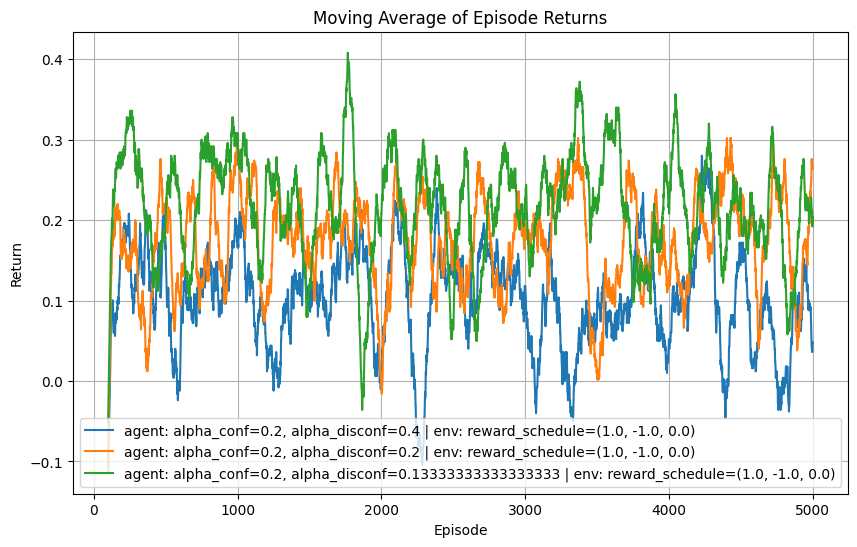

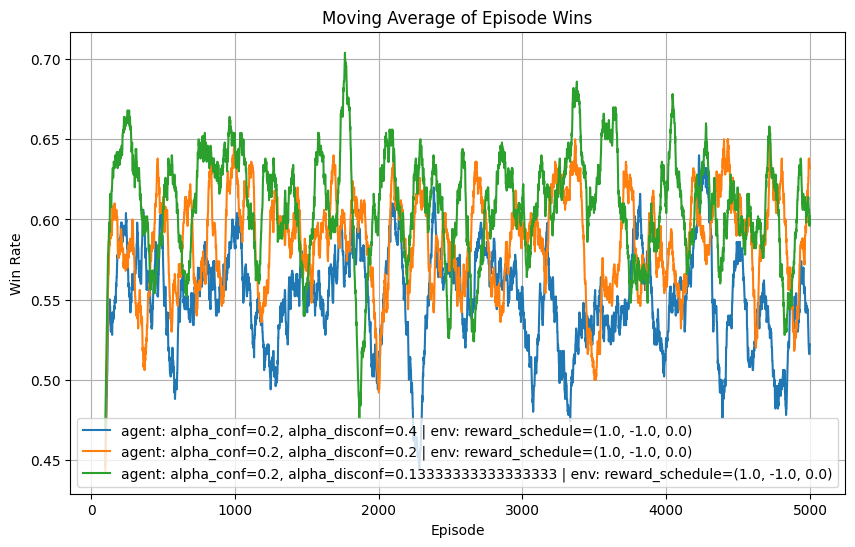

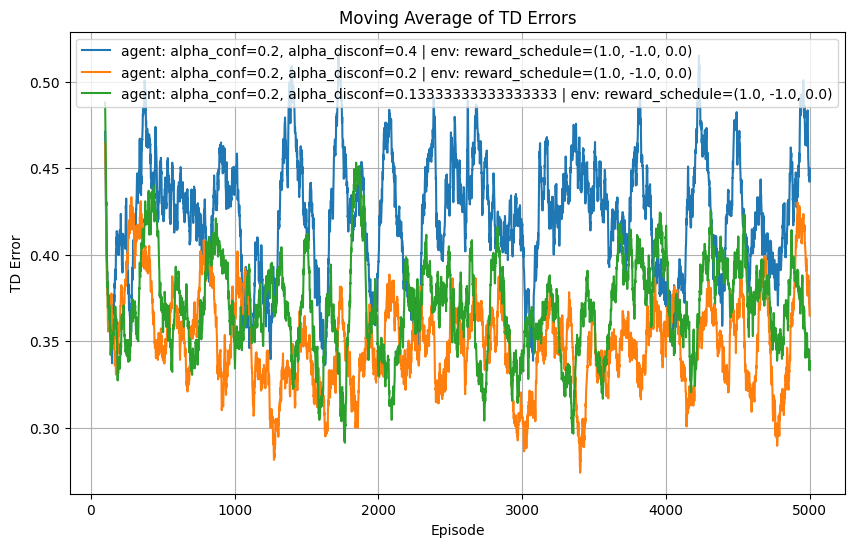

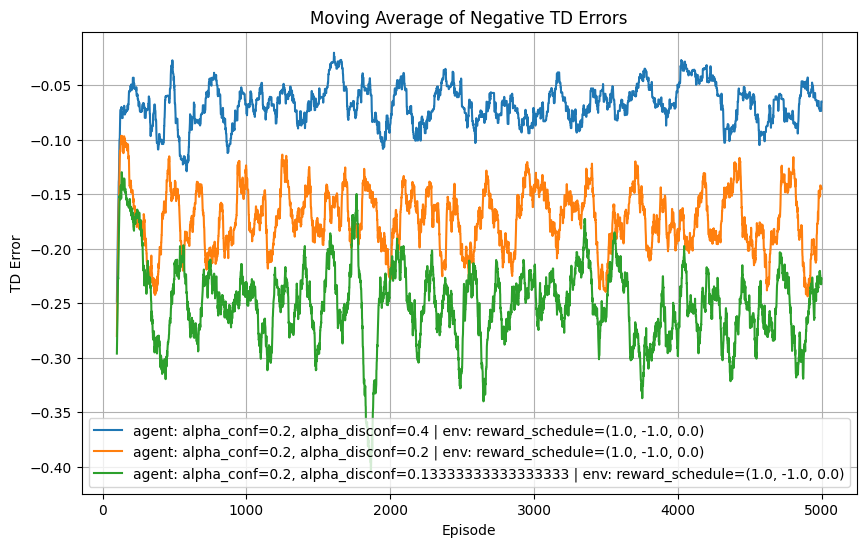

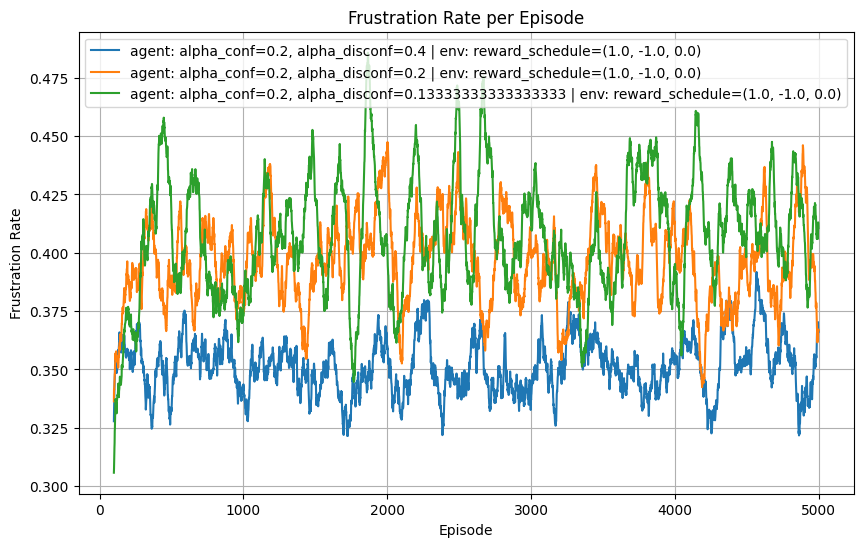

In [16]:
plot_sweep_training(results, window_size=100)

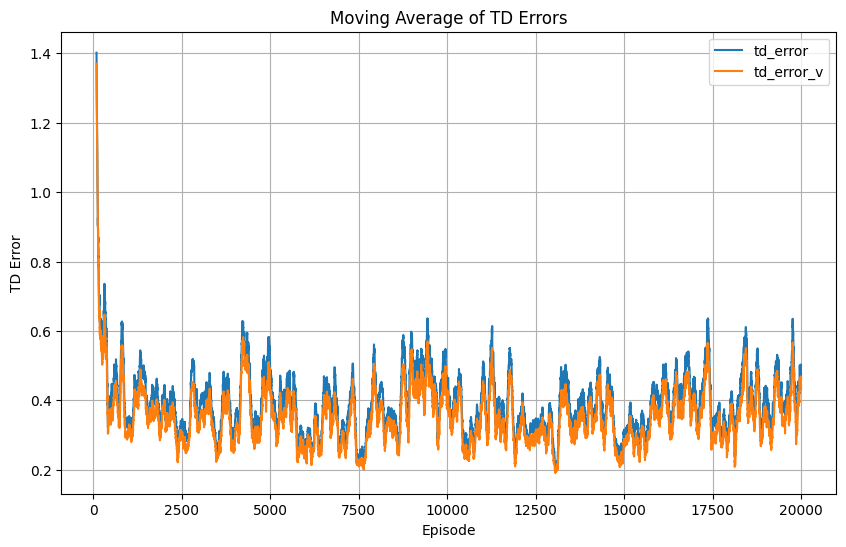

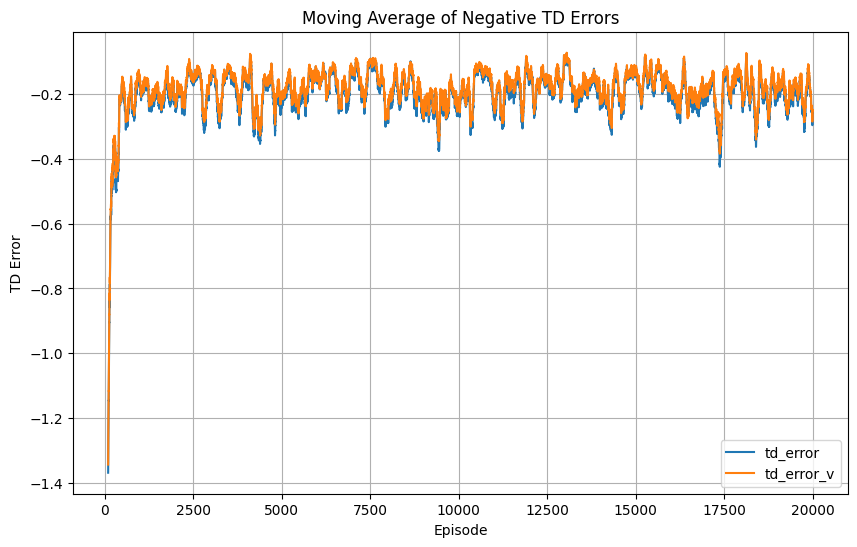

In [73]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)


/Users/aatukallio/frustration_msc/src/plots/evaluation_plots.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


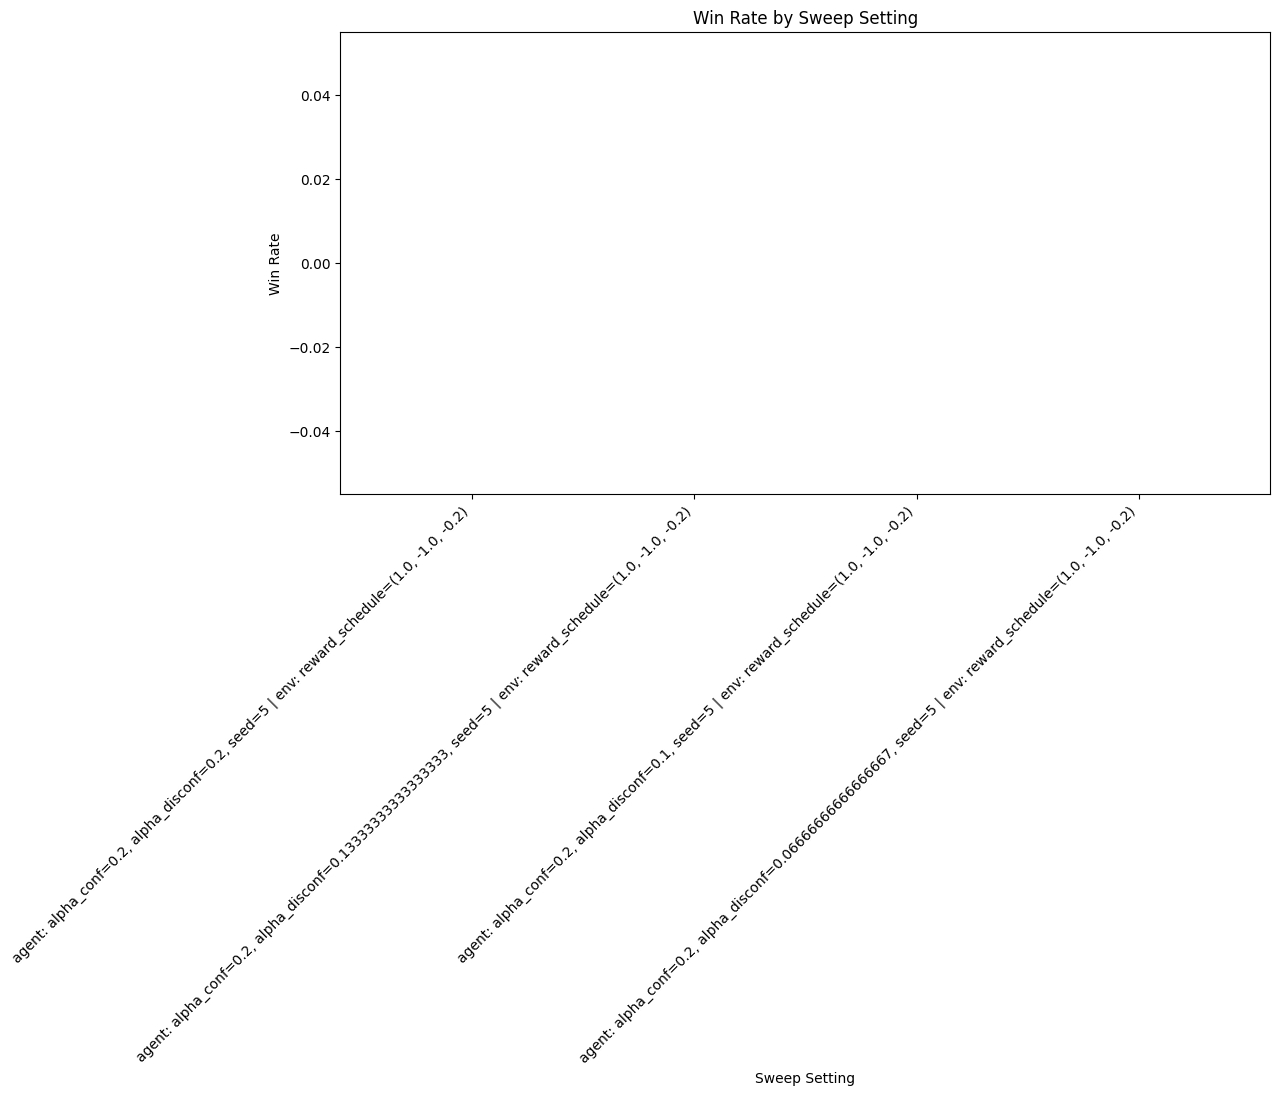

In [65]:
plot_sweep_evaluation(results)